In [ ]:
pip install scikit-fuzzy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 920.8/920.8 kB 10.8 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import skfuzzy as fuzz # Para C-Means

# Configuración de gráficas
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

print("Librerías cargadas correctamente.")

Librerías cargadas correctamente.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import skfuzzy as fuzz # Para C-Means

# Configuración de gráficas
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

print("Librerías cargadas correctamente.")

# 1. Cargar datos (Asegúrate de tener el archivo .csv en la misma carpeta o poner la ruta completa)
# Usamos 'low_memory=False' porque el archivo es gigante
# Si tu compu es lenta, añade: nrows=100000 para probar con una muestra primero
print("Cargando dataset...")
# Modificación: Usar engine='python' y on_bad_lines='skip' para manejar errores de parsing.
# Eliminamos low_memory=False ya que no es compatible con engine='python'
df = pd.read_csv('/content/COVID19MEXICO2020.csv', encoding='latin-1', engine='python', on_bad_lines='skip')

# 2. Filtrar solo CASOS POSITIVOS de COVID-19
# Según diccionario de datos: 1, 2 y 3 son positivos confirmados/asociación
df_pos = df[df['CLASIFICACION_FINAL'].isin([1, 2, 3])].copy()
print(f"Total de casos positivos analizados: {df_pos.shape[0]}")

# 3. Selección de variables de interés (Comorbilidades y Demografía)
features = ['EDAD', 'DIABETES', 'EPOC', 'ASMA', 'INMUSUPR',
            'HIPERTENSION', 'CARDIOVASCULAR', 'OBESIDAD', 'RENAL_CRONICA', 'TABAQUISMO']

df_model = df_pos[features].copy()

# 4. Limpieza de valores 'basura' (97, 98, 99 son "No sabe/No especificado")
# Convertimos 2 (No) -> 0
# Convertimos 1 (Sí) -> 1
# Eliminamos filas con 97, 98, 99
for col in features:
    if col != 'EDAD': # La edad no es binaria
        # Eliminar desconocidos
        df_model = df_model[df_model[col] < 97]
        # Convertir a binario real (1=Sí, 0=No)
        df_model[col] = df_model[col].apply(lambda x: 1 if x == 1 else 0)

print(f"Datos limpios listos para procesar: {df_model.shape[0]}")
df_model.head()

Librerías cargadas correctamente.
Cargando dataset...
Total de casos positivos analizados: 496291
Datos limpios listos para procesar: 493274


,EDAD,DIABETES,EPOC,ASMA,INMUSUPR,HIPERTENSION,CARDIOVASCULAR,OBESIDAD,RENAL_CRONICA,TABAQUISMO
0,55,1,0,0,0,0,0,0,0,0
3,35,0,0,0,0,0,0,0,0,0
15,56,1,0,0,0,0,0,0,0,0
18,58,1,0,0,0,0,0,0,0,0
20,37,0,0,0,0,0,0,0,0,0


In [ ]:
# Escalar los datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_model)

# Convertir a DataFrame para facilitar manejo posterior (opcional, pero útil)
X_final = pd.DataFrame(X_scaled, columns=features)
print("Datos normalizados.")

Datos normalizados.


Calculando método del codo...


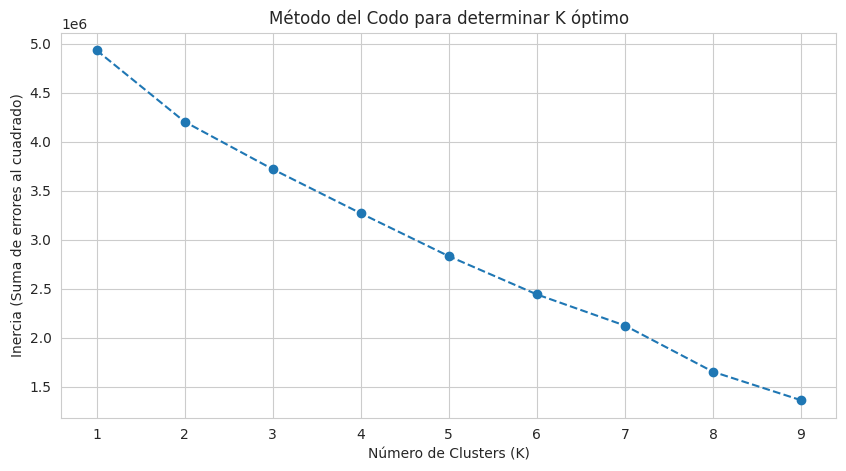

In [ ]:
# 1. Calcular la inercia para diferentes valores de K
sse = []
k_range = range(1, 10) # Probamos de 1 a 9 clusters

print("Calculando método del codo...")
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    sse.append(kmeans.inertia_)

# 2. Graficar el Codo
plt.figure(figsize=(10, 5))
plt.plot(k_range, sse, marker='o', linestyle='--')
plt.xlabel('Número de Clusters (K)')
plt.ylabel('Inercia (Suma de errores al cuadrado)')
plt.title('Método del Codo para determinar K óptimo')
plt.show()

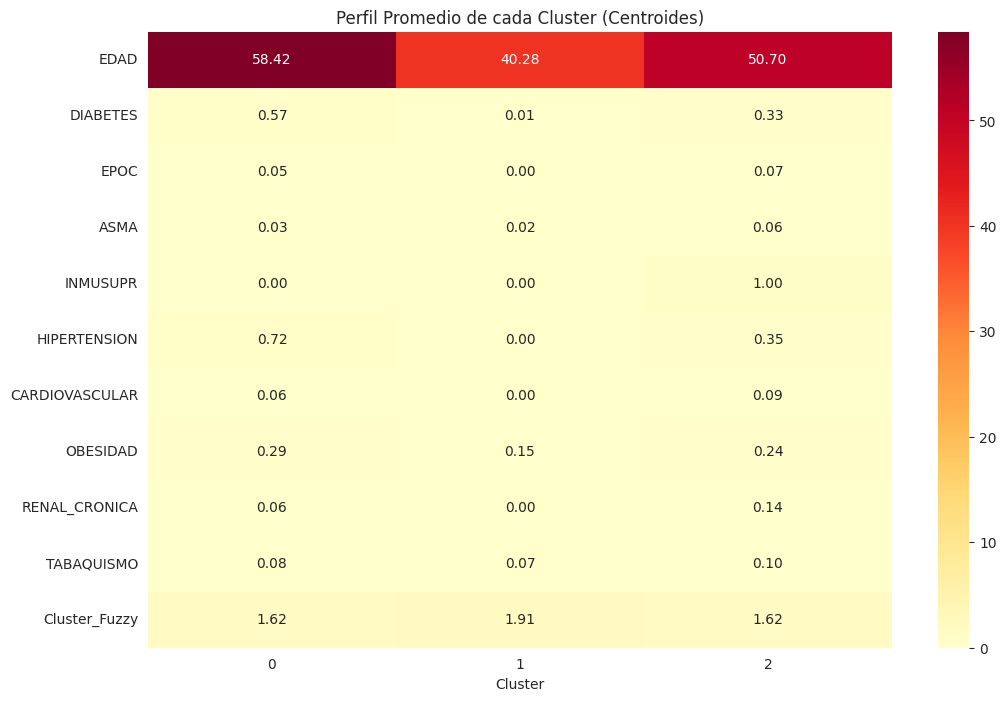

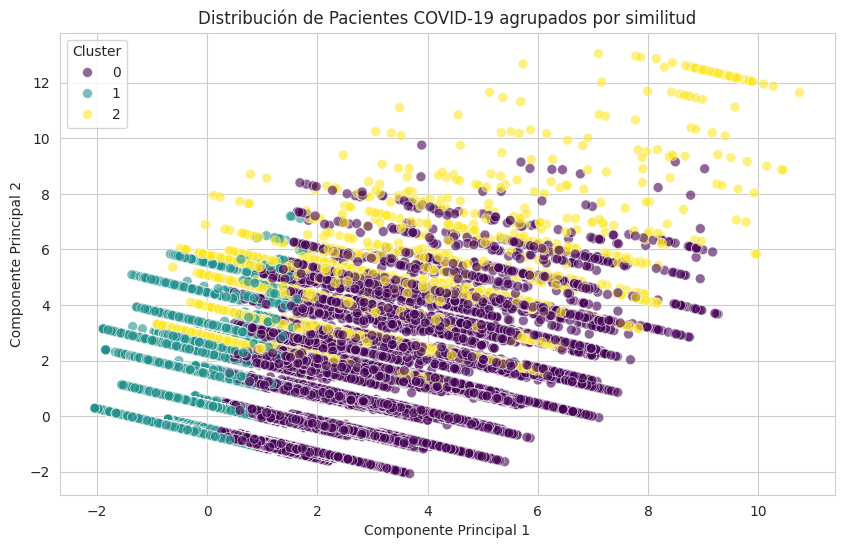

In [ ]:
# --- A. APLICAR K-MEANS ---
k_optimo = 3  # <--- SEGÚN GRÁFICA DEL CODO
kmeans = KMeans(n_clusters=k_optimo, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_scaled)

# Guardar los clusters en el dataframe original para analizar
df_model['Cluster'] = clusters

# --- B. INTERPRETACIÓN (HEATMAP) ---
# Esto es vital para tu sección de "Discusión de Resultados"
resumen_clusters = df_model.groupby('Cluster').mean().T

plt.figure(figsize=(12, 8))
sns.heatmap(resumen_clusters, annot=True, cmap='YlOrRd', fmt='.2f')
plt.title('Perfil Promedio de cada Cluster (Centroides)')
plt.show()

# --- C. VISUALIZACIÓN 2D (PCA) ---
pca = PCA(n_components=2)
pca_data = pca.fit_transform(X_scaled)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=pca_data[:,0], y=pca_data[:,1], hue=df_model['Cluster'], palette='viridis', s=50, alpha=0.6)
plt.title('Distribución de Pacientes COVID-19 agrupados por similitud')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.show()

In [ ]:
# C-Means necesita los datos transpuestos (Filas=Features, Cols=Pacientes)
data_fuzzy = X_scaled.T

# Ejecutar C-Means
# c = número de clusters (usa el mismo K que en K-means)
# m = grado de difusidad (2 es estándar)
cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
    data_fuzzy, c=k_optimo, m=2, error=0.005, maxiter=1000, init=None
)

# 'u' contiene la matriz de pertenencia (membership)
# Vamos a ver qué tan seguro está el algoritmo de asignar el primer paciente
print("Grado de pertenencia del primer paciente a cada cluster:")
for i in range(k_optimo):
    print(f"Cluster {i}: {u[i][0]*100:.2f}%")

# Asignar el cluster con mayor probabilidad (Hardening)
cluster_membership = np.argmax(u, axis=0)
df_model['Cluster_Fuzzy'] = cluster_membership

# Comparar K-Means vs Fuzzy
comparison = pd.crosstab(df_model['Cluster'], df_model['Cluster_Fuzzy'])
print("\nMatriz de coincidencia entre K-Means y C-Means:")
print(comparison)

Grado de pertenencia del primer paciente a cada cluster:
Cluster 0: 27.02%
Cluster 1: 45.81%
Cluster 2: 27.18%

Matriz de coincidencia entre K-Means y C-Means:
Cluster_Fuzzy      0       1       2
Cluster                             
0              26238  105948     127
1              57448    4581  293126
2               1768    2587    1451
